In [53]:
import chess.pgn
import re
import pandas as pd
import io 
import chess.polyglot
import chess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [54]:
# Function to filter PGNs with TimeControl into new PGN 
def filter_metadata_from_folder(folder_path, output_file, column_name):
    filtered_games = []

    # Iterate through files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".pgn"):  # Ensure it's a PGN file
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as pgn_file:
                while True:
                    game = chess.pgn.read_game(pgn_file) # to read and parse each game from the PGN text
                    if game is None:
                        break

                    # Extract metadata
                    metadata = game.headers
                    # Check if the desired column exists
                    if column_name in metadata:
                        filtered_games.append(game)

    # Write filtered games to a new PGN file
    with open(output_file, 'w') as output_pgn:
        for game in filtered_games:
            output_pgn.write(str(game) + "\n\n")


input_folder = r"C:\Users\Admin\AIP\Magnus PGN data" # Path to the folder containing input PGN files
output_file = "filtered_output.pgn"  # Output file name
column_name = "TimeControl"  # Metadata column to filter


filter_metadata_from_folder(input_folder, output_file, column_name)


# Data Preprocessing
-Read PGN File
-Validate Game
-Extract Metadata ,Moves and Clock Times

In [56]:
def extract_clock_time(comment):
    # Implement this function based on how you extract clock times from comments
    # For example, if clock times are formatted as "[%clk 1:23:45]", you can use regex to extract them
    import re
    match = re.search(r'%clk\s([0-9]+:[0-9]+:[0-9]+)', comment)
    return match.group(1) if match else ""

In [57]:
# Data validation
def is_valid_game(game):
    # Validate metadata
    required_headers = ['Event', 'Date', 'Round', 'White', 'Black', 'Result']
    for header in required_headers:
        if header not in game.headers:
            return False

    # Validate game result
    if game.headers['Result'] not in ['1-0', '0-1', '1/2-1/2']:
        return False

    # Validate ELO ratings if available
    if 'WhiteElo' in game.headers and 'BlackElo' in game.headers:
        try:
            white_elo = int(game.headers['WhiteElo'])
            black_elo = int(game.headers['BlackElo'])
            if white_elo <= 0 or black_elo <= 0:
                return False
        except ValueError:
            return False

    # Validate moves
    board = game.board()
    for move in game.mainline_moves():
        if not board.is_legal(move):
            return False
        board.push(move)

    return True


In [34]:
def read_pgn_file(file_path):
    rows = []

    with open(file_path, "r") as pgn_file:
        while True:
            game = chess.pgn.read_game(pgn_file)
            
            if game is None:
                break

            # Validate game before extracting data
            if not is_valid_game(game):
                continue

            # Extract metadata
            metadata = {
                "Event": game.headers["Event"],
                "Date": game.headers["Date"],
                "Round": game.headers["Round"],
                "White": game.headers["White"],
                "Black": game.headers["Black"],
                "Result": game.headers["Result"],
                "Board": game.headers.get("Board", ""),
                "TimeControl": game.headers.get("TimeControl", ""),
                "WhiteFideId": game.headers.get("WhiteFideId", ""),
                "BlackFideId": game.headers.get("BlackFideId", ""),
                "WhiteElo": game.headers.get("WhiteElo", ""),
                "BlackElo": game.headers.get("BlackElo", ""),
                "WhiteTeam": game.headers.get("WhiteTeam", ""),
                "BlackTeam": game.headers.get("BlackTeam", "")
            }

            # Extract moves and clock times
            moves = []
            times = []
            node = game
            while not node.is_end():
                next_node = node.variation(0)
                board = node.board()
                move_san = board.san(next_node.move)
                comment = next_node.comment

                # Extract clock time from the comment, if available
                clock_time = extract_clock_time(comment)

                moves.append(move_san)
                times.append(clock_time)

                node = next_node

            # Combine metadata and moves data into one row
            combined_row = {**metadata}
            for i, (move, time) in enumerate(zip(moves, times), start=1):
                combined_row[f"Move_{i}"] = move
                combined_row[f"Time_{i}"] = time

            # Append the combined row to the list of rows
            rows.append(combined_row)
    
    return rows

# Set the path to the PGN file
pgn_file_path = "filtered_output.pgn"

# Read games from the PGN file
rows = read_pgn_file(pgn_file_path)

# Create DataFrame
df_combined = pd.DataFrame(rows)

# Write DataFrame to CSV
df_combined.to_csv("magnus_game_data.csv", index=False)

print("Data successfully written to magnus_game_data.csv")


Data successfully written to magnus_game_data.csv


In [35]:
num_rows = len(df_combined)
print("Number of rows in the DataFrame:", num_rows)

Number of rows in the DataFrame: 918


In [36]:
# Print columns and their data types
print("DataFrame Columns and Data Types:")
print(df_combined.dtypes)

DataFrame Columns and Data Types:
Event       object
Date        object
Round       object
White       object
Black       object
             ...  
Time_269    object
Move_270    object
Time_270    object
Move_271    object
Time_271    object
Length: 556, dtype: object


In [37]:
df_combined

,Event,Date,Round,White,Black,Result,Board,TimeControl,WhiteFideId,BlackFideId,...,Move_267,Time_267,Move_268,Time_268,Move_269,Time_269,Move_270,Time_270,Move_271,Time_271
0,Grand Chess Tour: SuperUnited Rapid & Blitz Cr...,2023.07.07,8,"Carlsen, Magnus","Duda, Jan-Krzysztof",1-0,4,1500+10,1503014,1170546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Grand Chess Tour: SuperUnited Rapid & Blitz Cr...,2023.07.08,11,"Carlsen, Magnus","Duda, Jan-Krzysztof",1-0,3,300+2,1503014,1170546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Grand Chess Tour: SuperUnited Rapid & Blitz Cr...,2023.07.08,13,"Carlsen, Magnus","Saric, Ivan",1-0,1,1500+10,1503014,14508150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Grand Chess Tour: SuperUnited Rapid & Blitz Cr...,2023.07.08,17,"Carlsen, Magnus","Rapport, Richard",1-0,4,1500+10,1503014,738590,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Grand Chess Tour: SuperUnited Rapid & Blitz Cr...,2023.07.08,15,"Carlsen, Magnus","Nepomniachtchi, Ian",1-0,4,1500+10,1503014,4168119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,Titled Tuesday Blitz July 4 Late 2023,2023.07.04,5,"Carlsen, Magnus","Korobov, Anton",1-0,1,180+2,1503014,14105730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
914,Titled Tuesday Blitz July 4 Late 2023,2023.07.04,11,"Carlsen, Magnus","Bortnyk, Olexandr",1-0,1,180+2,1503014,14120828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
915,Titled Tuesday Blitz July 4 Late 2023,2023.07.04,9,"Carlsen, Magnus","Mamedov, Rauf",1-0,1,180+2,1503014,13401653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
916,Titled Tuesday Blitz July 4 Late 2023,2023.07.04,7,"Carlsen, Magnus","Bluebaum, Matthias",1-0,1,180+2,1503014,24651516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#Dropping unnecessary columns

columns_to_drop = ['Event', 'Round', 'Board', 'WhiteFideId', 'BlackFideId', 'WhiteTeam', 'BlackTeam'] 
                  
df_combined = df_combined.drop(columns=columns_to_drop)

# Display the first few rows to verify
print(df_combined.head())

# Check the remaining columns
print(df_combined.columns)


         Date            White                Black Result TimeControl  \
0  2023.07.07  Carlsen, Magnus  Duda, Jan-Krzysztof    1-0     1500+10   
1  2023.07.08  Carlsen, Magnus  Duda, Jan-Krzysztof    1-0       300+2   
2  2023.07.08  Carlsen, Magnus          Saric, Ivan    1-0     1500+10   
3  2023.07.08  Carlsen, Magnus     Rapport, Richard    1-0     1500+10   
4  2023.07.08  Carlsen, Magnus  Nepomniachtchi, Ian    1-0     1500+10   

  WhiteElo BlackElo Move_1   Time_1 Move_2  ... Move_267 Time_267 Move_268  \
0     2829     2794     d4  0:25:19    Nf6  ...      NaN      NaN      NaN   
1     2829     2794     d4  0:04:48    Nf6  ...      NaN      NaN      NaN   
2     2829     2635     e4  0:05:03     c5  ...      NaN      NaN      NaN   
3     2829     2761     e4  0:05:02    Nf6  ...      NaN      NaN      NaN   
4     2829     2760     d4  0:05:03    Nf6  ...      NaN      NaN      NaN   

  Time_268 Move_269 Time_269 Move_270 Time_270 Move_271 Time_271  
0      NaN      NaN

In [39]:
# Count the number of NaN values in a column
nan_count = df_combined['TimeControl'].isna().sum()
print("Number of NaN values in the column:", nan_count)

Number of NaN values in the column: 0


In [40]:
# Count the number of null values in a particular column
null_count_column = df_combined['TimeControl'].isnull().sum()
print("Number of null values in the column:", null_count_column)

Number of null values in the column: 0


In [41]:
#Count unique values of a column in a DataFrame
unique_counts = df_combined['TimeControl'].value_counts()

# Print the unique value counts
print(unique_counts)

180+1                 192
180+2                 169
900+10                144
60                     78
5400+30                41
60+1                   40
900+3                  39
600+2                  34
300+1                  33
1500+10                32
300                    20
35+0                   18
40/5400+30:1800+30     14
300+2                  10
3+2                    10
7200+10                 7
15+10                   7
2700+10                 6
300+3                   6
6000+30                 5
90' + 30' & 30"         4
40/600:0+1              3
40/7200:0+10            3
15+3                    2
600+10                  1
Name: TimeControl, dtype: int64


# Feature Engineering

Classical: time control of more than 60 minutes per player.

Rapid: time control of more than 10 minutes but less than 60 minutes per player.

Blitz:  time control of 10 minutes or less per player.

In [42]:
def classify_time_control(time_control):
    # Split the time control string by colon ':' to handle multiple time controls
    time_controls = time_control.split(':')
    
    # Initialize a list to store the classification results for each time control
    time_control_types = []
    
    # Iterate over each time control
    for control in time_controls:
        try:
            # Initialize main time and increment
            main_time = None
            increment = None
            
            # Check if '+' or '/' is present in the time control string
            if '+' in control:
                # Split the time control by '+' to extract main time and increment
                main_time, increment = control.split('+')
            elif '/' in control:
                # Split the time control by '/' to extract main time and increment
                main_time, increment = control.split('/')
            else:
                # Handle other formats or set default values
                time_control_types.append('Unknown')
                continue  # Skip to the next time control
            
            # Convert main_time to an integer
            main_time = int(main_time)
            
            # Classify based on main time
            if main_time >= 180:
                time_control_types.append('Classical')
            elif main_time >= 60:
                time_control_types.append('Rapid')
            else:
                time_control_types.append('Blitz')
        except ValueError:
            # Handle cases where parsing fails (e.g., invalid literal for int)
            time_control_types.append('InvalidFormat')
            continue  # Skip to the next time control
    
    # Join the classification results for multiple time controls with colon ':'
    return ':'.join(time_control_types)

In [43]:
df_combined['TimeControlType'] = df_combined['TimeControl'].apply(classify_time_control)

In [44]:
# Count unique values of a column in a DataFrame
unique_counts = df_combined['TimeControlType'].value_counts()

# Print the unique value counts
print(unique_counts)

Classical                  719
Unknown                     98
Rapid                       40
Blitz                       37
InvalidFormat:Classical     14
Blitz:Blitz                  6
InvalidFormat                4
Name: TimeControlType, dtype: int64


In [45]:
# Function to get the first few moves

def get_opening_moves(row, num_moves=4):
    moves = [row[f'Move_{i}'] for i in range(1, num_moves+1) if f'Move_{i}' in row and pd.notnull(row[f'Move_{i}'])]
    return ' '.join(moves)

df_combined['OpeningMoves'] = df_combined.apply(lambda row: get_opening_moves(row), axis=1)


In [46]:
df_combined

,Date,White,Black,Result,TimeControl,WhiteElo,BlackElo,Move_1,Time_1,Move_2,...,Move_268,Time_268,Move_269,Time_269,Move_270,Time_270,Move_271,Time_271,TimeControlType,OpeningMoves
0,2023.07.07,"Carlsen, Magnus","Duda, Jan-Krzysztof",1-0,1500+10,2829,2794,d4,0:25:19,Nf6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Classical,d4 Nf6 c4 e6
1,2023.07.08,"Carlsen, Magnus","Duda, Jan-Krzysztof",1-0,300+2,2829,2794,d4,0:04:48,Nf6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Classical,d4 Nf6 c4 e6
2,2023.07.08,"Carlsen, Magnus","Saric, Ivan",1-0,1500+10,2829,2635,e4,0:05:03,c5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Classical,e4 c5 Nf3 d6
3,2023.07.08,"Carlsen, Magnus","Rapport, Richard",1-0,1500+10,2829,2761,e4,0:05:02,Nf6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Classical,e4 Nf6 e5 Nd5
4,2023.07.08,"Carlsen, Magnus","Nepomniachtchi, Ian",1-0,1500+10,2829,2760,d4,0:05:03,Nf6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Classical,d4 Nf6 c4 e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,2023.07.04,"Carlsen, Magnus","Korobov, Anton",1-0,180+2,3255,3018,b3,0:03:00,d5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Classical,b3 d5 Bb2 c5
914,2023.07.04,"Carlsen, Magnus","Bortnyk, Olexandr",1-0,180+2,3281,3047,b3,0:03:00,d5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Classical,b3 d5 Bb2 Bf5
915,2023.07.04,"Carlsen, Magnus","Mamedov, Rauf",1-0,180+2,3271,3064,e4,0:03:00,c5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Classical,e4 c5 Nf3 d6
916,2023.07.04,"Carlsen, Magnus","Bluebaum, Matthias",1-0,180+2,3262,3043,a3,0:03:00,d5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Classical,a3 d5 Nf3 Nf6


In [47]:
summary_stats = df_combined.describe()
print(summary_stats)

              Date            White             Black Result TimeControl  \
count          918              918               918    918         918   
unique         256                2               292      3          25   
top     2023.07.21  Carlsen, Magnus  Nakamura, Hikaru    1-0       180+1   
freq            36              900                63    590         192   

       WhiteElo BlackElo Move_1   Time_1 Move_2  ... Move_268 Time_268  \
count       918      918    918      918    918  ...        1        1   
unique      187      503     18      138     18  ...        1        1   
top        2830     2632     e4  0:03:00     e5  ...      Kd8  0:01:13   
freq        106       18    444      173    259  ...        1        1   

       Move_269 Time_269 Move_270 Time_270 Move_271 Time_271 TimeControlType  \
count         1        1        1        1        1        1             918   
unique        1        1        1        1        1        1               7   
top     

In [48]:
# Identifying columns containing moves
move_columns = [col for col in df_combined.columns if col.startswith('Move_')]

# function to extract the opening moves for both players
def extract_opening_moves(row):
    opening_moves = []
    for col in move_columns:
        if pd.notnull(row[col]):
            opening_moves.append(row[col])
            if len(opening_moves) == 2:  # Break the loop once moves from both players are found
                break
    return ' '.join(opening_moves)

# Creating a new column 'OpeningMoves' to store the opening moves of both players
df_combined['OpeningMoves'] = df_combined.apply(extract_opening_moves, axis=1)


In [49]:
# Calculate the frequency of each unique opening move
opening_moves_frequency = df_combined['OpeningMoves'].value_counts()

# Print the top 10 opening moves
print("Top 10 Opening Moves:")
print(opening_moves_frequency.head(10))

Top 10 Opening Moves:
e4 e5      209
d4 Nf6     140
e4 c5      139
d4 d5       43
Nf3 d5      37
Nf3 Nf6     32
e4 e6       26
b3 d5       23
c4 Nf6      19
e4 g6       19
Name: OpeningMoves, dtype: int64


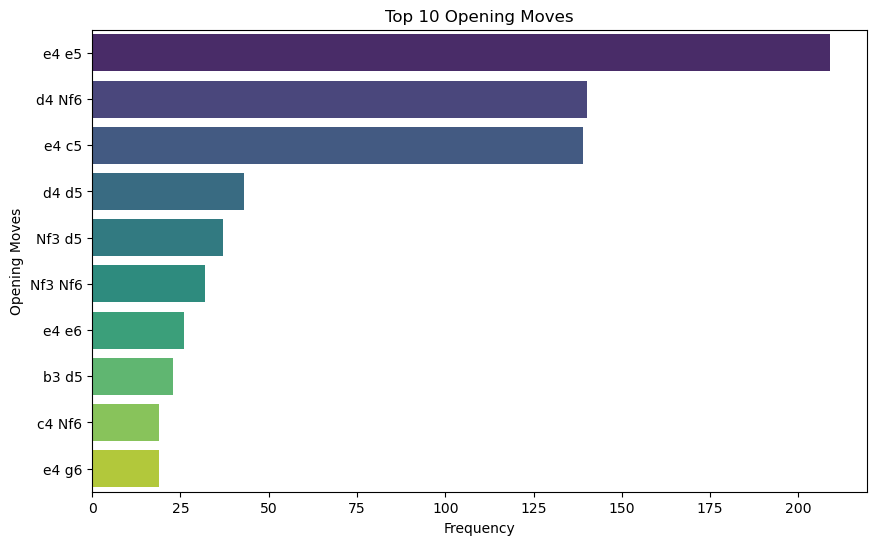

In [50]:
opening_moves_frequency = df_combined['OpeningMoves'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=opening_moves_frequency.index, x=opening_moves_frequency.values, palette='viridis')
plt.title('Top 10 Opening Moves')
plt.xlabel('Frequency')
plt.ylabel('Opening Moves')
plt.show()

In [51]:
from collections import Counter


# Example move columns might be named 'Move_1', 'Move_2', ...
move_columns = [col for col in df_combined.columns if col.startswith('Move_')]

def determine_game_phase(move_number):
    """
    Determines the game phase based on the move number.
    :param move_number: The current move number in the game.
    :return: The game phase ('opening', 'middlegame', 'endgame').
    """
    if move_number <= 30:
        return 'opening'
    elif move_number <= 80:
        return 'middlegame'
    else:
        return 'endgame'

def get_phase_moves(chess_data, move_columns):
    """
    Extracts and counts the frequency of moves in each phase of the game.
    :param chess_data: DataFrame containing chess game data.
    :param move_columns: List of columns containing moves.
    :return: Dictionary with phase-wise move frequencies.
    """
    phase_moves = {'opening': Counter(), 'middlegame': Counter(), 'endgame': Counter()}
    
    for index, row in chess_data.iterrows():
        for i, col in enumerate(move_columns):
            move = row[col]
            if pd.notnull(move):
                phase = determine_game_phase(i + 1)
                phase_moves[phase][move] += 1
    
    return phase_moves

# Get the phase-wise move frequencies
phase_moves = get_phase_moves(df_combined, move_columns)

# Print the top moves for each phase
for phase in phase_moves:
    print(f"Top moves in {phase}:")
    for move, count in phase_moves[phase].most_common(10):
        print(f"{move}: {count}")


Top moves in opening:
O-O: 1407
Nf3: 899
Nf6: 867
d4: 726
d5: 674
e4: 659
Nc6: 641
Nc3: 603
e5: 588
c4: 477
Top moves in middlegame:
h4: 361
h5: 326
a5: 294
a4: 288
f5: 280
b4: 251
b5: 246
f4: 242
g5: 242
g4: 238
Top moves in endgame:
Kf3: 189
Kg6: 184
Kg7: 179
Ke6: 179
Kf6: 177
Ke3: 171
Kf7: 167
Ke4: 163
Kd6: 161
Ke5: 160
